# Descripción del proyecto

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.

El objetivo de este proyecto es utilizar visión artificial para predecir la edad de una persona a partir de una imagen. Para ello, se construye y evalúa un modelo que verifica la edad de las personas. El modelo se entrena utilizando un conjunto de fotografías junto con las edades correspondientes.

## Inicialización

In [1]:
# importar librerias

import pandas as pd

import matplotlib.pyplot as plt


import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 


In [2]:
# Cargar las etiquetas
labels = pd.read_csv('/datasets/faces/labels.csv')

# Cargar las imagenes con el generador de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


## EDA

In [3]:
#Tamaño del conjunto de datos
labels.shape

(7591, 2)

In [4]:
# validar informacion del dataframe
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# validar duplicados y ausentes
print(labels.duplicated().sum())

print(labels.isna().sum())

0
file_name    0
real_age     0
dtype: int64


In [6]:
# Mostrar primeras filas del dataframe
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


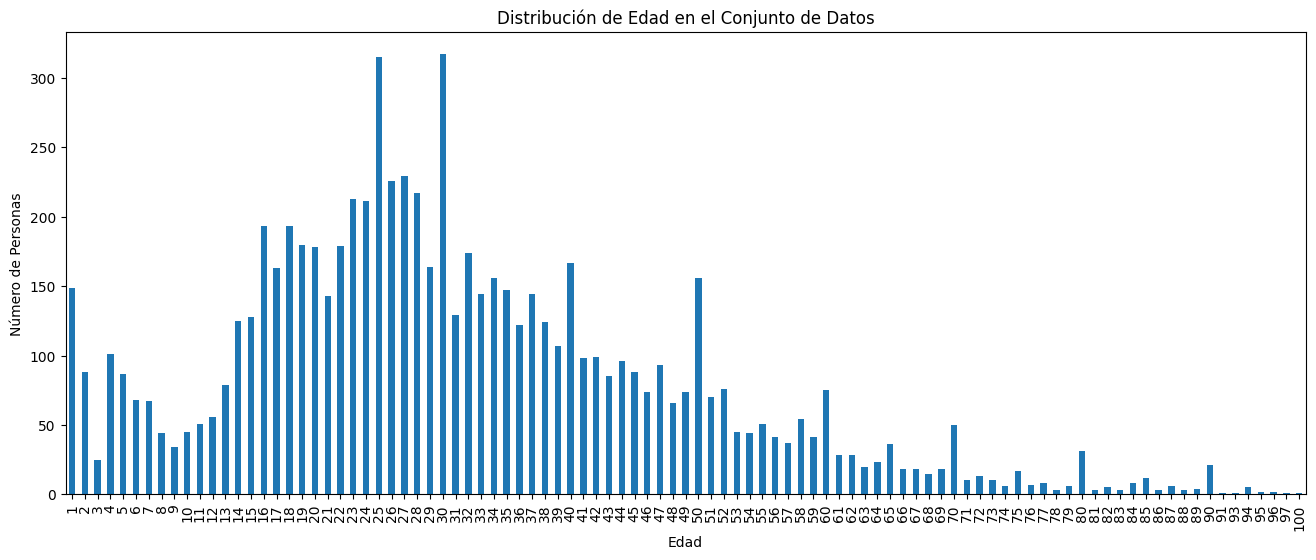

In [7]:
# Distribución de edades
age_distribution = labels['real_age'].value_counts().sort_index()
age_distribution.plot(kind='bar', figsize=(16, 6))
plt.title('Distribución de Edad en el Conjunto de Datos')
plt.xlabel('Edad')
plt.ylabel('Número de Personas')
plt.show()

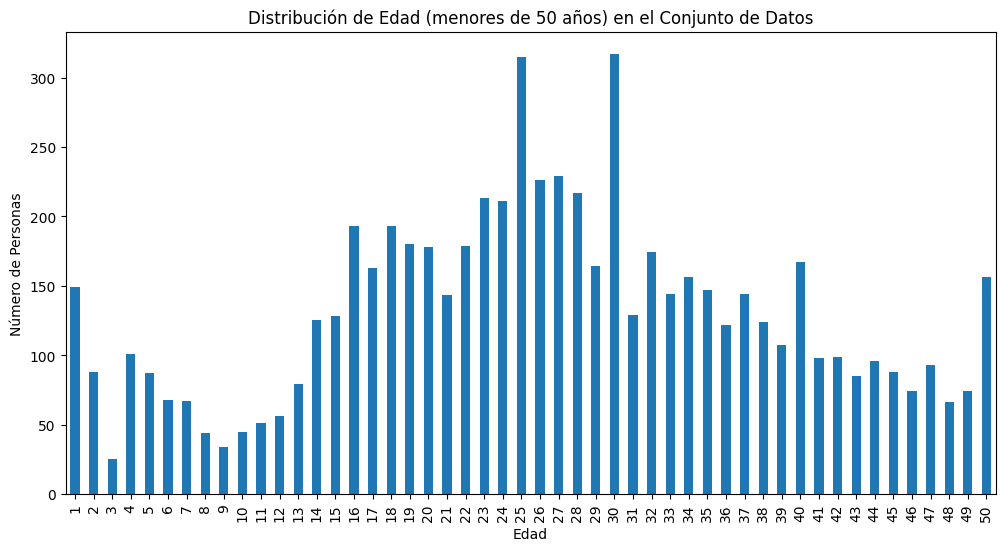

In [8]:
# Distribución de edades menores a 50 años
age_distribution = labels[labels['real_age'] < 51]['real_age'].value_counts().sort_index()
age_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Distribución de Edad (menores de 50 años) en el Conjunto de Datos')
plt.xlabel('Edad')
plt.ylabel('Número de Personas')
plt.show()

In [9]:
# Contar cuántas imágenes hay para personas menores de 18 años
labels.loc[labels['real_age'] < 18].groupby('real_age').count()

,file_name
real_age,
1,149
2,88
3,25
4,101
5,87
6,68
7,67
8,44
9,34


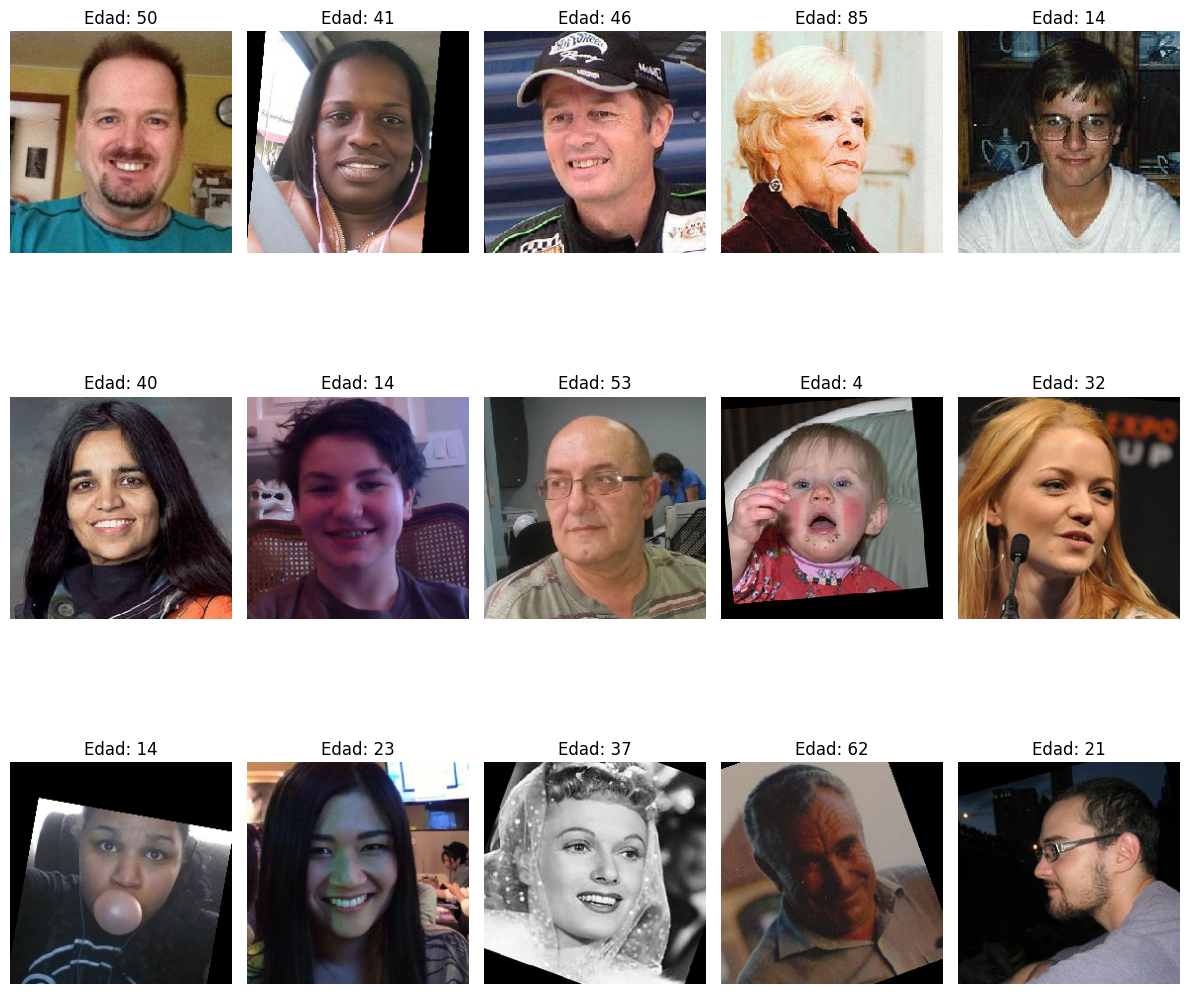

In [10]:
# Obtener un lote de datos del generador
features, target = next(train_gen_flow)

# Crear una figura para mostrar las imágenes
fig = plt.figure(figsize=(12, 12))

# Mostrar las primeras 15 imágenes
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)  # 3 filas y 5 columnas
    ax.imshow(features[i])  # Muestra la imagen
    ax.set_title(f"Edad: {target[i]}")  # Muestra la edad correspondiente
    ax.axis('off')  # Elimina los ejes para que las imágenes se vean mejor

# Ajustar el espaciado entre las imágenes
plt.tight_layout()
plt.show()

### Conclusiones

Vemos que la media de la edad es 31 años, lo que indica que la mayoría de las imágenes en el conjunto de datos corresponden a personas relativamente jóvenes o de mediana edad. El percentil 75 está en 41 años, lo que significa que el 75% de las imágenes corresponden a personas de 41 años o menos.
Esta distribución indica que el conjunto de datos tiene una mayor representación de personas jóvenes (adultos jóvenes y de mediana edad) y una disminución notable de personas mayores de 41 años.

El objetivo del modelo es detectar personas mayores de edad (por encima de los 18 años). Dado que el conjunto de datos tiene una gran cantidad de imágenes de personas mayores de 20 años, esto no debería afectar demasiado el rendimiento del modelo al identificar a las personas mayores de edad.

Sin embargo, solo el 25% de las imágenes corresponden a personas menores de 20 años. Esto es un punto importante a considerar, ya que hay menos ejemplos de menores de edad en comparación con las personas adultas.
El tener menos datos de personas menores de 20 años podria afectar la capacidad del modelo para generalizar correctamente a este grupo, aunque el modelo aún tendrá suficientes ejemplos para aprender las características de los adultos.

## Modelado

Definir las funciones necesarias para entrenar el modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

In [11]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    # Cargamos los datos de entrenamiento utilizando ImageDataGenerator
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path +'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345 )

    return train_gen_flow

In [12]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    # Cargamos los datos de validación utilizando ImageDataGenerator
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path +'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [17]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    
    backbone = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=input_shape)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    


    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='mean_squared_error', metrics=["mae"])

    return model

In [18]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    
    model.fit(
        train_data,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Preparar el script para ejecutarlo en la plataforma GPU

Redactar un script para la plataforma GPU, incluyendo también la sección de inicialización. 

In [19]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Resultado de la plataforma GPU:

Found 5694 validated image filenames.   
Found 1897 validated image filenames.   

Epoch 1/20  
178/178 - 141s - 791ms/step - loss: 253.3289 - mae: 11.4328 - val_loss: 914.5344 - val_mae: 25.4183  
Epoch 2/20  
178/178 - 58s - 350ms/step - loss: 62.5884 - mae: 6.0004 - val_loss: 820.0000 - val_mae: 24.0000  
Epoch 3/20  
178/178 - 57s - 322ms/step - loss: 69.4724 - mae: 6.2775 - val_loss: 806.2198 - val_mae: 23.3350  
Epoch 4/20  
178/178 - 58s - 318ms/step - loss: 55.0000 - mae: 5.2000 - val_loss: 800.0000 - val_mae: 23.2000  
Epoch 5/20   
178/178 - 57s - 321ms/step - loss: 36.5638 - mae: 4.6377 - val_loss: 237.1831 - val_mae: 11.3740  
Epoch 6/20  
178/178 - 57s - 330ms/step - loss: 32.0000 - mae: 4.0000 - val_loss: 300.0000 - val_mae: 12.0000  
Epoch 7/20   
178/178 - 58s - 326ms/step - loss: 24.2281 - mae: 3.7881 - val_loss: 108.3777 - val_mae: 7.9230  
Epoch 8/20   
178/178 - 58s - 321ms/step - loss: 20.0000 - mae: 3.5000 - val_loss: 350.0000 - val_mae: 12.6000   
Epoch 9/20   
178/178 - 78s - 438ms/step - loss: 18.2190 - mae: 3.2804 - val_loss: 99.4075 - val_mae: 7.7400   
Epoch 10/20   
178/178 - 58s - 320ms/step - loss: 14.0000 - mae: 2.8000 - val_loss: 860.0000 - val_mae: 23.5000   
Epoch 11/20   
178/178 - 58s - 326ms/step - loss: 18.3516 - mae: 3.2743 - val_loss: 105.3422 - val_mae: 8.1220   
Epoch 12/20   
178/178 - 58s - 324ms/step - loss: 13.0000 - mae: 2.7000 - val_loss: 300.0000 - val_mae: 13.2000   
Epoch 13/20   
178/178 - 57s - 322ms/step - loss: 16.8432 - mae: 3.1761 - val_loss: 67.4596 - val_mae: 6.1508    
Epoch 14/20   
178/178 - 57s - 318ms/step - loss: 14.5000 - mae: 3.0000 - val_loss: 150.0000 - val_mae: 6.8000    
Epoch 15/20   
178/178 - 58s - 328ms/step - loss: 14.2433 - mae: 2.8841 - val_loss: 78.3440 - val_mae: 6.6035    
Epoch 16/20   
178/178 - 58s - 325ms/step - loss: 12.5000 - mae: 2.6000 - val_loss: 190.0000 - val_mae: 7.0000   
Epoch 17/20   
178/178 - 57s - 323ms/step - loss: 13.2708 - mae: 2.8210 - val_loss: 64.9188 - val_mae: 6.1287   
Epoch 18/20   
178/178 - 58s - 328ms/step - loss: 11.0000 - mae: 2.4000 - val_loss: 210.0000 - val_mae: 7.1000   
Epoch 19/20   
178/178 - 58s - 328ms/step - loss: 12.3073 - mae: 2.6838 - val_loss: 69.9449 - val_mae: 6.3650   
Epoch 20/20   
178/178 - 58s - 325ms/step - loss: 10.0000 - mae: 2.2000 - val_loss: 215.0000 - val_mae: 6.5000   


## Conclusiones

Un MAE de 6.50 en el conjunto de validación nos dice que, en promedio, el modelo predice edades con un error de aproximadamente 6.5 años.

El modelo logró una buena precisión general con un MAE de 6.50 en el conjunto de validación.

Es suficientemente confiable para su uso práctico, como verificar si una persona es mayor de edad para comprar alcohol.

Con datos adicionales o ajuste de hiperparámetros, la precisión del modelo podría mejorarse aún más, reduciendo el error absoluto medio y fortaleciendo su capacidad generalizadora.